<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/jax-cosmo-paper/blob/master/notebooks/DES_Y1_3x2pt_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using JAX-cosmo on a Roman-like analysis, compare Fisher with different n(z)

In [1]:
# If running on Colab
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git
!git clone https://github.com/DifferentiableUniverseInitiative/jax-cosmo-paper.git


fatal: destination path 'jax-cosmo-paper' already exists and is not an empty directory.
/global/u1/c/chihway/jax-cosmo-paper/notebooks/jax-cosmo-paper


In [98]:
%pylab inline
import os
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpy as onp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['np', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Retrieving  the nz data

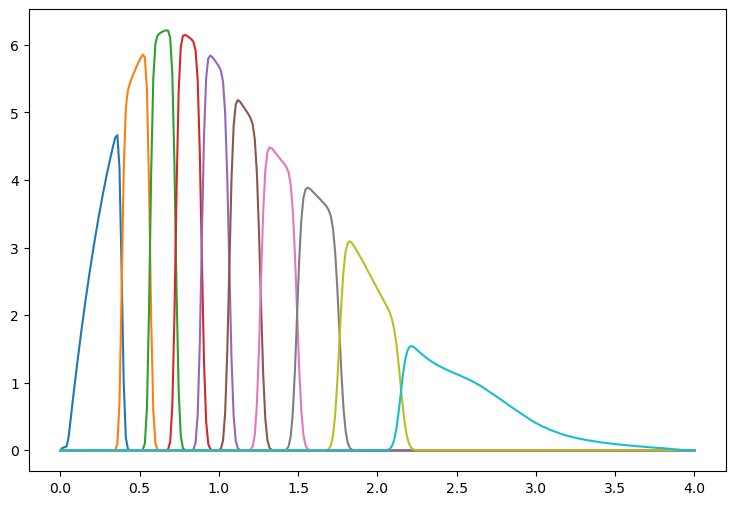

In [99]:
figure(figsize=(9,6))

Z = []
NZ = []

for i in range(10):
    z = onp.loadtxt('../nofz/reference/WFIRST_zdist_sources_bin'+str(i)+'.txt')[:,0]
    nz = onp.loadtxt('../nofz/reference/WFIRST_zdist_sources_bin'+str(i)+'.txt')[:,1]
    
    
    # Let's plot the NZs
    plot(z, nz)
    Z.append(z)
    NZ.append(nz)

Z = np.array(Z)
NZ = np.array(NZ)

In [100]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1]

nzs_s = [jc.redshift.kde_nz(Z[i], NZ[i], 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i])
           for i in range(10)]

(0.0, 4.0)

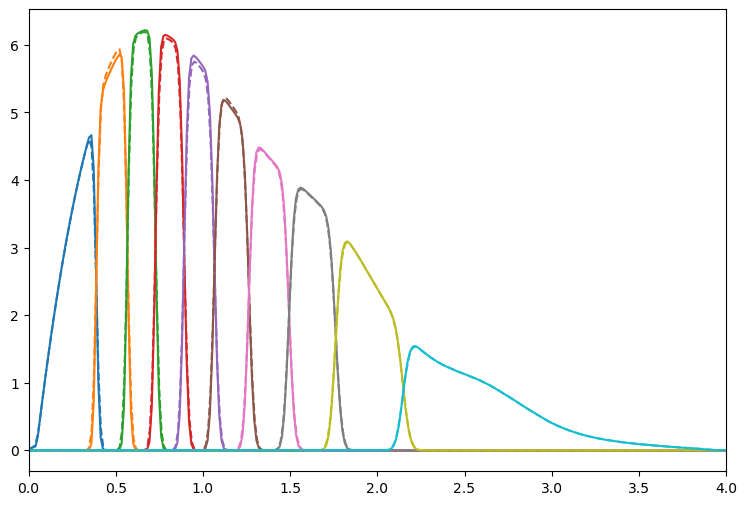

In [101]:
z = linspace(0,4, 300)

figure(figsize=(9,6))

for i in range(10):
    plot(Z[i], NZ[i], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,4)


##  Let's build  a model for C_ell

In [102]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = m
    dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8, dz9, dz10 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0, cosmo.wa,
        # Shear systematics
        m1, m2, m3, m4, m5, m6, m7, m8, m9, m10,
        # Photoz systematics
        dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8, dz9, dz10, 
        # IA model
        A, eta,
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=params[6])
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = params[7:17]
    dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8, dz9, dz10 = params[17:27]
    A = params[27]
    eta = params[28]
    return cosmo, [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], [dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8, dz9, dz10], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.], [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.],
              [1., 2.])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [Array(1., dtype=float32),
  Array(2., dtype=float32),
  Array(3., dtype=float32),
  Array(4., dtype=float32),
  Array(5., dtype=float32),
  Array(6., dtype=float32),
  Array(7., dtype=float32),
  Array(8., dtype=float32),
  Array(9., dtype=float32),
  Array(10., dtype=float32)],
 [Array(1., dtype=float32),
  Array(2., dtype=float32),
  Array(3., dtype=float32),
  Array(4., dtype=float32),
  Array(5., dtype=float32),
  Array(6., dtype=float32),
  Array(7., dtype=float32),
  Array(8., dtype=float32),
  Array(9., dtype=float32),
  Array(10., dtype=float32)],
 [Array(1., dtype=float32), Array(2., dtype=float32)])

In [103]:
# Define some ell range
ell = np.logspace(np.log10(20), np.log10(1000))
#ell = np.logspace(np.log10(20), np.log10(500))

print(ell)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

[  19.999996   21.66221    23.462572   25.412563   27.52462    29.812212
   32.28993    34.973564   37.880245   41.0285     44.438408   48.131714
   52.131977   56.464703   61.157543   66.24039    71.745674   77.70849
   84.1669     91.162094   98.73865   106.944885  115.83318   125.46013
  135.88718   147.1809    159.41316   172.66216   187.01218   202.55496
  219.38951   237.62306   257.372     278.76248   301.93054   327.0243
  354.20343   383.64163   415.5265    450.06107   487.4661    527.9796
  571.8602    619.3881    670.8661    726.62244   787.0123    852.42126
  923.2669   1000.      ]


In [104]:
# Let's try it out
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1., Omega_k=0., wa=0.)

fid_params = get_params_vec(fid_cosmo, 
                            [0., 0., 0., 0.,0., 0., 0., 0.,0., 0.],
                            [0., 0., 0., 0.,0., 0., 0., 0.,0., 0.],
                            [0.5, 0.])

In [105]:
cl_gg = mu(fid_params)

/global/homes/c/chihway/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/c/chihway/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=devi

In [106]:
## Building a Fisher matrix, we just need the covarianc
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m, 
                                   sigmae=0.26)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.04848136811095359, 
                                               sparse=False)
    
    return cov

In [107]:
fid_params.shape

(29,)

In [108]:
C = cov(fid_params)

In [109]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [110]:
j = jacobian(fid_params)

In [111]:
%timeit jacobian(fid_params).block_until_ready()

5.32 s ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
import scipy

def symmetrized_matrix(U):
    u"""Return a new matrix like `U`, but with upper-triangle elements copied to lower-triangle ones."""
    M = U.copy()
    inds = onp.triu_indices_from(M,k=1)
    M[(inds[1], inds[0])] = M[inds]
    return M

def symmetric_positive_definite_inverse(M):
    u"""Compute the inverse of a symmetric positive definite matrix `M`.

    A :class:`ValueError` will be thrown if the computation cannot be
    completed.

    """
    import scipy.linalg
    U,status = scipy.linalg.lapack.dpotrf(M)
    if status != 0:
        raise ValueError("Non-symmetric positive definite matrix")
    M,status = scipy.linalg.lapack.dpotri(U)
    if status != 0:
        raise ValueError("Error in Cholesky factorization")
    M = symmetrized_matrix(M)
    return M

In [113]:
C.shape

(2750, 2750)

In [114]:
j64 = onp.array(j).astype(onp.float64)
C64 = onp.array(C).astype(onp.float64)

In [115]:
# And we get the fisher matrix from the jacobian and covariance
CC = symmetric_positive_definite_inverse(C64)
F = onp.einsum('ia,ij,jb->ab', j64, CC, j64)
F = 0.5*(F + F.T)

In [116]:
F.shape

(29, 29)

In [117]:
# cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
#                      h=params[3], n_s=params[4], w0=params[5],
#                      Omega_k=0., wa=params[6])
# m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = params[7:17]
# dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8, dz9, dz10 = params[17:27]
# A = params[27]
# eta = params[28]

############
# COSMOLOGY
############

# # LSST priors
# sigma_sigma8 = 0.14
# sigma_omega_c = 0.2
# sigma_omega_b = 0.006
# sigma_h = 0.063
# sigma_ns = 0.08
# sigma_w0 = 0.8
# sigma_wa = 2.0

# # 10xLSST priors (probably too optimistic)
# sigma_sigma8 = 0.14*10
# sigma_omega_c = 0.2*10
# sigma_omega_b = 0.006*10
# sigma_h = 0.063*10
# sigma_ns = 0.08*10
# sigma_w0 = 0.8*10
# sigma_wa = 2.0*10

# priors consistent with Eifler et al. (2020)
# omega_m [0.1, 0.6] 0.3156
# sigma_8 [0.6, 0.95] 0.831
# ns [0.85, 1.06] 0.9645
# w0 [-2, 0] -1
# wa [-2.5, 2.5] 0
# omega_b [0.04, 0.055] 0.0492
# h0 [0.6, 0.76] 0.6727
# TATT and baryons are used

# one option is to conserve the second moment, which leads to the tophat width = 2L = sqrt(3) sigma
sigma_sigma8 = (0.95 - 0.6) / np.sqrt(3)
sigma_omega_c = ((0.6-0.0492) - (0.1-0.0492)) / np.sqrt(3)
sigma_omega_b = (0.055 - 0.04) / np.sqrt(3)
sigma_h = (0.76 - 0.6) / np.sqrt(3)
sigma_ns = (1.06 - 0.85) / np.sqrt(3)
sigma_w0 = (0. - (-2)) / np.sqrt(3)
sigma_wa = (2.5 - (-2.5)) / np.sqrt(3)

############
# IA
############

# use NLA here with two parameters, assume flat priors [-5,5] for each of them
# not following Eifler here since it uses TATT

sigma_A = (5 - (-5))/np.sqrt(3)
sigma_eta = (5 - (-5))/np.sqrt(3)

############
# SHEAR CALIBRATION
############

# this follows Eifler et al.

sigma_m_opt = 0.002

############
# PHOTOZ
############

# this follows Eifler et al.

sigma_z_opt = 0.002


# Add priors ##########

import numpy as onp

# first include everything
d = onp.zeros(29)

d[0] = 1./(sigma_sigma8)**2
d[1] = 1./(sigma_omega_c)**2
d[2] = 1./(sigma_omega_b)**2
d[3] = 1./(sigma_h)**2
d[4] = 1./(sigma_ns)**2
d[5] = 1./(sigma_w0)**2
d[6] = 1./(sigma_wa)**2

d[7:17] = 1./(sigma_m_opt)**2
d[17:27] = 1./(sigma_z_opt)**2

d[27] = 1./(sigma_A)**2
d[28] = 1./(sigma_eta)**2

# only cosmology
d2 = onp.zeros(29)

d2[0] = 1./(sigma_sigma8)**2
d2[1] = 1./(sigma_omega_c)**2
d2[2] = 1./(sigma_omega_b)**2
d2[3] = 1./(sigma_h)**2
d2[4] = 1./(sigma_ns)**2
d2[5] = 1./(sigma_w0)**2
d2[6] = 1./(sigma_wa)**2

# cosmology and shear
d3 = onp.zeros(29)

d3[0] = 1./(sigma_sigma8)**2
d3[1] = 1./(sigma_omega_c)**2
d3[2] = 1./(sigma_omega_b)**2
d3[3] = 1./(sigma_h)**2
d3[4] = 1./(sigma_ns)**2
d3[5] = 1./(sigma_w0)**2
d3[6] = 1./(sigma_wa)**2

d3[7:17] = 1./(sigma_m_opt)**2

# cosmology and shear and photo-z
d4 = onp.zeros(29)

d4[0] = 1./(sigma_sigma8)**2
d4[1] = 1./(sigma_omega_c)**2
d4[2] = 1./(sigma_omega_b)**2
d4[3] = 1./(sigma_h)**2
d4[4] = 1./(sigma_ns)**2
d4[5] = 1./(sigma_w0)**2
d4[6] = 1./(sigma_wa)**2

d4[7:17] = 1./(sigma_m_opt)**2
d4[17:27] = 1./(sigma_z_opt)**2

# no cosmology
d5 = onp.zeros(29)

d5[7:17] = 1./(sigma_m_opt)**2
d5[17:27] = 1./(sigma_z_opt)**2

d5[27] = 1./(sigma_A)**2
d5[28] = 1./(sigma_eta)**2

F_noprior = F.copy()
F_romanprior = F + np.diag(d)
F_cosmoprior = F + np.diag(d2)
F_cosmoshearprior = F + np.diag(d3)
F_cosmoshearpzprior = F + np.diag(d4)
F_nocosmoprior = F + np.diag(d5)


In [118]:
# cov_estimate = symmetric_positive_definite_inverse(F)
# onp.savetxt('cov_estimate_from_fisher.txt', cov_estimate)


In [119]:
def is_symmetric(X):
    return onp.all(X == X.T)

is_symmetric(F)

True

In [120]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=1., ax=None, resize=False, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  xy = [pos[i], pos[j]]
  ellip = Ellipse(xy=xy, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  if resize:
    sz = max(width, height)
    s1 = 1.5*nstd*sigma_marg(i)
    s2 = 1.5*nstd*sigma_marg(j)
    ax.set_xlim(pos[i] - s1, pos[i] + s1)
    ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

In [121]:
# Ellipse?

In [122]:
fid_params

Array([ 0.801 ,  0.2545,  0.0485,  0.682 ,  0.971 , -1.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.5   ,
        0.    ], dtype=float32)

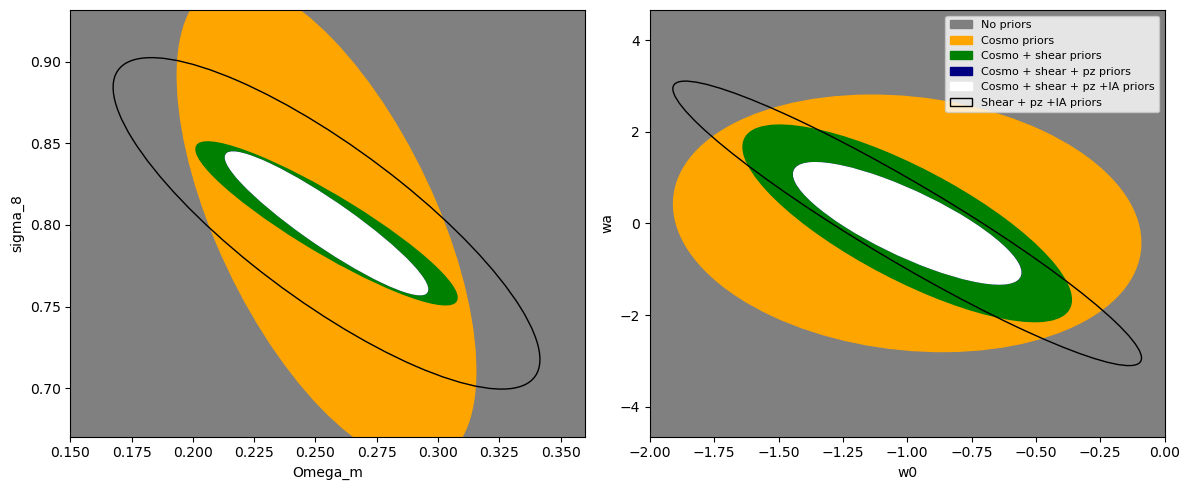

In [123]:
figure(figsize=(12,5))

subplot(121)
plot_contours(F_noprior, fid_params, 1, 0, resize=True, color='grey', label='No priors')
plot_contours(F_cosmoprior, fid_params, 1, 0, resize=True, color='orange', label='Cosmo priors')
plot_contours(F_cosmoshearprior, fid_params, 1, 0, resize=True, color='g', label='Cosmo + shear priors')
plot_contours(F_cosmoshearpzprior, fid_params, 1, 0, resize=True, color='navy', label='Cosmo + shear + pz priors')
plot_contours(F_romanprior, fid_params, 1, 0, resize=True, color='w', label='Cosmo + shear + pz +IA priors')
plot_contours(F_nocosmoprior, fid_params, 1, 0, resize=True, color='k', lw=1, fc='none', label='Shear + pz +IA priors')

xlabel('Omega_m')
ylabel('sigma_8')
# legend(loc=1, fontsize=8)
xlim(0.15, 0.36)

subplot(122)
plot_contours(F_noprior, fid_params, 5, 6, resize=True, color='grey', label='No priors')
plot_contours(F_cosmoprior, fid_params, 5, 6, resize=True, color='orange', label='Cosmo priors')
plot_contours(F_cosmoshearprior, fid_params, 5, 6, resize=True, color='g', label='Cosmo + shear priors')
plot_contours(F_cosmoshearpzprior, fid_params, 5, 6, resize=True, color='navy', label='Cosmo + shear + pz priors')
plot_contours(F_romanprior, fid_params, 5, 6, resize=True, color='w', label='Cosmo + shear + pz +IA priors')
plot_contours(F_nocosmoprior, fid_params, 5, 6, resize=True, color='k', lw=1, fc='none', label='Shear + pz +IA priors')

xlabel('w0')
ylabel('wa')
legend(loc=1, fontsize=8)
xlim(-2, 0)

tight_layout()

### Other things to look at
* sensitivity to scales
* constraints on other parameters
* constraints as a function of redshift bins
* double check cosmo priors
* think about IA - does it make sense that it does not matter?
* add 3x2pt
* update fiducial cosmo